Origin-destination matrix estimation

Possibly useful for constructing P matrix: probability of going through edges when moving from A to B

- https://openrouteservice.org/services/  (e.g. nearest)
- Google Maps API, maybe Google Distance Matrix API, maybe Google Geotagging API
- https://www.opentripplanner.org/ (Helps: https://github.com/jeromemayaud/OpenTripPlanner-OD-matrix)
Directions API: Directions between multiple locations, Distance Matrix API: Travel times and distances between locations<br>
Routes API: Performance optimized versions of the Directions and Distance Matrix APIs<br>
Roads API: Snap-to-road functionality to accurately trace GPS breadcrumbs.  maybe Places API

"QNEAT3 OD Matrix Calculation": https://github.com/kahlulz/Olongapo-City-Hospital-Network-Analysis<br>
Spatial Analysis: QGIS is utilized to conduct spatial analysis. Hospital locations were mapped, and distance-based calculations were performed using QNEAT3 OD Matrix Calculation. <br>
https://gis.stackexchange.com/questions/403556/what-unit-is-represented-by-od-matix-costs-in-qneat3-within-qgis-3-6-noosa?newreg=400dd6f344ab480a959ecfc8002019b9 <br>
https://root676.github.io/OdMatrixAlgs.html <br>
https://www.qgistutorials.com/en/docs/3/origin_destination_matrix.html

In [3]:
import json
key = json.loads(open('keys.json').read())[""]

In [2]:
import geojson

# Create a point
point = geojson.Point((-115.81, 37.24))

# Create a feature
feature = geojson.Feature(geometry=point, properties={"country": "USA"})

# Create a FeatureCollection
feature_collection = geojson.FeatureCollection([feature])

# Dump to a GeoJSON string
geojson_str = geojson.dumps(feature_collection)

print(geojson_str)

{"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"type": "Point", "coordinates": [-115.81, 37.24]}, "properties": {"country": "USA"}}]}


Paths: with Google

In [ ]:
import googlemaps

gmaps = googlemaps.Client(key=key)
directions_result = gmaps.directions("Hegyeshalom", "Mosonszolnok", alternatives=True)
#Possible directions test
for i, route in enumerate(directions_result):
    print(f"Route {i+1}:")
    for step in route['legs'][0]['steps']:  
        print(step['html_instructions'])
    print("\n\n")

Route 1:
Head <b>southwest</b> on <b>Alkotmány u.</b>
Turn <b>left</b>
Turn <b>right</b> at <b>Orgona u.</b>
Turn <b>right</b>
Turn <b>left</b>
Continue onto <b>Szabadság út</b>
Turn <b>right</b> onto <b>Jókai u.</b><div style="font-size:0.9em">Destination will be on the right</div>



Route 2:
Head <b>northeast</b> on <b>Alkotmány u.</b> toward <b>Damjanich u.</b>
Turn <b>right</b> onto <b>Damjanich u.</b>
Turn <b>left</b> onto <b>Szolnoki u.</b>
Continue onto <b>Kertalja u.</b>
Turn <b>right</b> onto <b>Fő u.</b>/<wbr/><b>Route 1</b><div style="font-size:0.9em">Continue to follow Route 1</div>
At the roundabout, take the <b>3rd</b> exit and stay on <b>Route 1</b>
At the roundabout, take the <b>2nd</b> exit and stay on <b>Route 1</b>
Turn <b>right</b> onto <b>Szolnoki út</b>
Continue onto <b>Óvári u.</b>
Continue onto <b>Fő u.</b>
Turn <b>left</b> onto <b>Szabadság út</b>
Turn <b>right</b> onto <b>Jókai u.</b><div style="font-size:0.9em">Destination will be on the right</div>



Route

In [ ]:
import geopandas as gpd
import pandas as pd

gdf = gpd.read_file("data/Hungary_2022_static_road_data.geojson")

In [3]:
gdf

,id,kszam,pkod,kszelv,vszelv,asz,anf,oj,ongj,ev,geometry
0,963,M43,1,5 + 260,5 + 539,3923.0,34512,24481.0,5587.0,2022,"MULTILINESTRING ((731774.360 106214.871, 73205..."
1,1466,M4,1,226 + 756,227 + 082,2791.0,5290,3170.0,1364.0,2022,"MULTILINESTRING ((848187.895 212117.248, 84819..."
2,1667,M4,1,220 + 355,226 + 756,2790.0,3718,2281.0,924.0,2022,"MULTILINESTRING ((842594.594 213060.017, 84323..."
3,1988,M4,1,219 + 930,220 + 355,2790.0,3718,2281.0,924.0,2022,"MULTILINESTRING ((842351.564 213406.554, 84259..."
4,2958,M4,1,215 + 102,219 + 930,2790.0,3718,2281.0,924.0,2022,"MULTILINESTRING ((839509.502 217300.342, 83958..."
...,...,...,...,...,...,...,...,...,...,...,...
17105,9191,4,2,112 + 335,112 + 359,3447.0,14805,10571.0,2591.0,2022,"MULTILINESTRING ((749173.505 205163.170, 74917..."
17106,7848,4,2,112 + 359,112 + 385,3447.0,14805,10571.0,2591.0,2022,"MULTILINESTRING ((749160.453 205182.069, 74916..."
17107,8584,4,2,112 + 385,112 + 402,3447.0,14805,10571.0,2591.0,2022,"MULTILINESTRING ((749173.505 205202.752, 74917..."
17108,8648,4,2,112 + 402,112 + 426,3447.0,14805,10571.0,2591.0,2022,"MULTILINESTRING ((749190.307 205202.752, 74919..."


MULTILINESTRING ((742842.017364 208331.18787, 742881.887994 208316.64793, 742919.553978 208303.350431, 742959.717634 208289.635297, 742997.649848 208277.117432, 743035.705341 208264.979508, 743076.270125 208252.500625, 743114.567851 208241.150122, 743152.977166 208230.183158, 743191.494229 208219.600828, 743230.115187 208209.404192, 743268.836178 208199.594269, 743310.082508 208189.596045, 743348.997579 208180.586772, 743383.120707 208173.023218, 743414.864613 208166.26751, 743446.66236 208159.769941, 743478.51185 208153.530941, 743510.410981 208147.550921, 743544.816989 208141.400981, 743576.812486 208135.960085, 743608.851133 208130.779329, 743640.930816 208125.859055, 743673.049416 208121.199588, 743707.67977 208116.473724, 743739.872423 208112.356896, 743772.097461 208108.501767, 743804.352759 208104.90859, 743836.636186 208101.577603, 743871.431968 208098.283857, 743911.235077 208094.884265, 743953.565655 208091.642802, 744000.914423 208088.380057, 744053.282878 208085.092144, 744

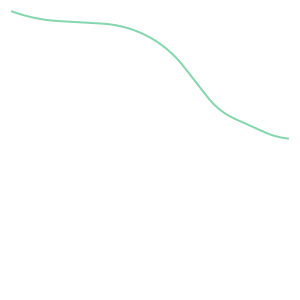

In [25]:
n=13
print(gdf['geometry'][n])
display(gdf['geometry'][n])

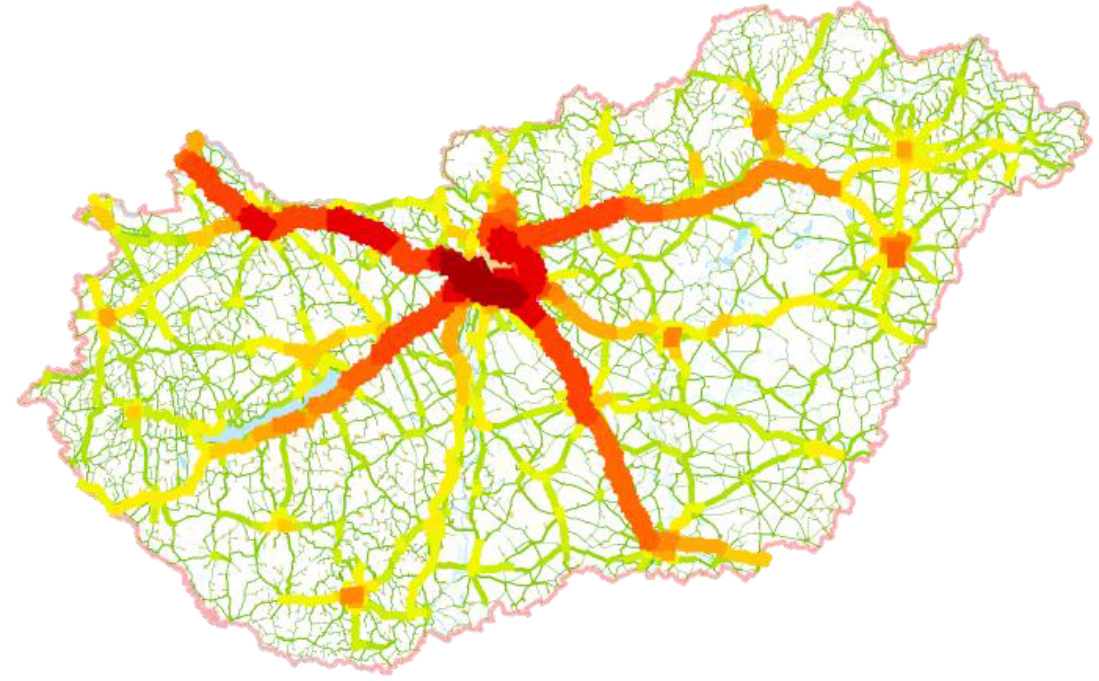

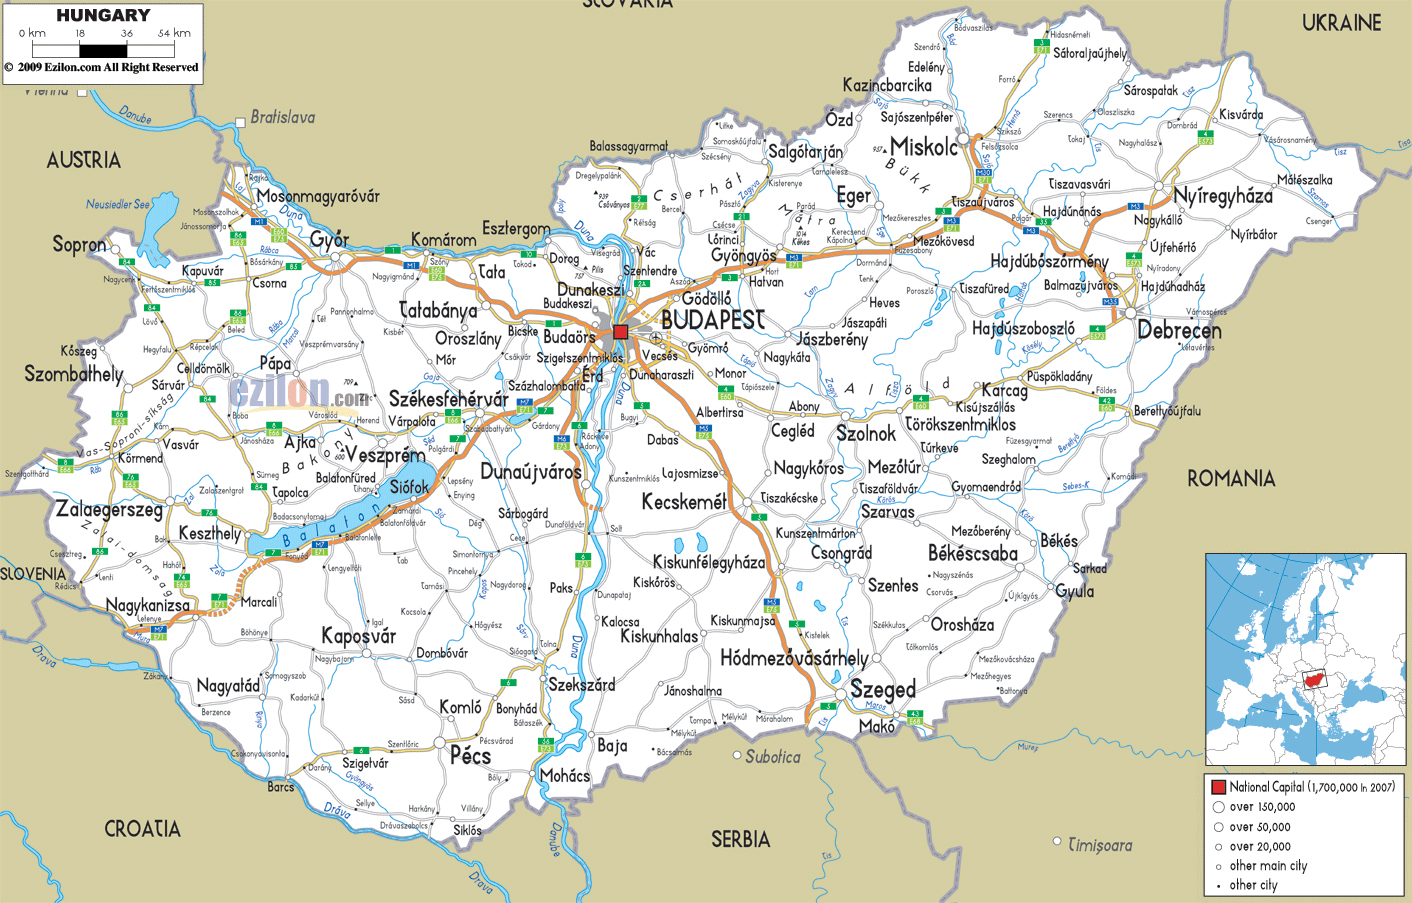

<Axes: >

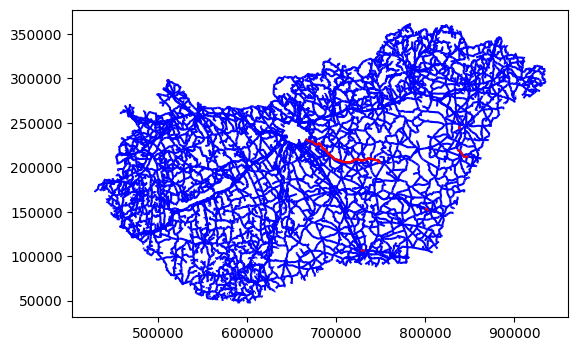

In [32]:
ax = gdf.plot(color='blue', )#alpha=0.5, edgecolor='k'

gdf.head(100).plot(ax=ax, color='red')

<Axes: >

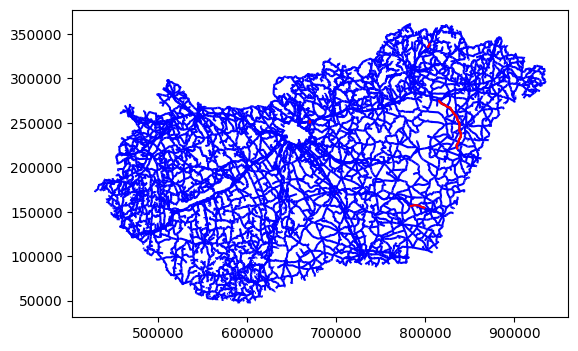

In [43]:
ax = gdf.plot(color='blue', )#alpha=0.5, edgecolor='k'

gdf[107:170].plot(ax=ax, color='red')

In [42]:
gdf[100:150]

,id,kszam,pkod,kszelv,vszelv,asz,anf,oj,ongj,ev,geometry
100,4525,M4,1,29 + 514,34 + 052,2712.0,35936,31155.0,2771.0,2022,"MULTILINESTRING ((674411.800 227657.871, 67443..."
101,4087,M4,1,29 + 321,29 + 514,2712.0,35936,31155.0,2771.0,2022,"MULTILINESTRING ((674265.030 227783.644, 67429..."
102,12994,M4,1,25 + 667,29 + 321,3529.0,57443,49521.0,4396.0,2022,"MULTILINESTRING ((670934.562 228919.951, 67197..."
103,12379,M4,1,23 + 738,25 + 667,6031.0,39233,35863.0,1626.0,2022,"MULTILINESTRING ((669081.669 229242.849, 66911..."
104,11361,M4,1,20 + 453,23 + 738,6031.0,39233,35863.0,1626.0,2022,"MULTILINESTRING ((666410.782 230966.636, 66642..."
105,12758,M4,1,20 + 185,20 + 453,6031.0,39233,35863.0,1626.0,2022,"MULTILINESTRING ((666159.207 230877.302, 66618..."
106,11680,M4,1,19 + 550,20 + 185,6031.0,39233,35863.0,1626.0,2022,"MULTILINESTRING ((665657.019 230488.778, 66566..."
107,544,M35,2,67 + 499,67 + 790,2786.0,10875,7561.0,2055.0,2022,"MULTILINESTRING ((835765.325 220367.704, 83572..."
108,2029,M35,2,63 + 853,67 + 499,2786.0,10875,7561.0,2055.0,2022,"MULTILINESTRING ((835285.821 223907.508, 83529..."
109,2302,M35,2,63 + 318,63 + 853,2786.0,10875,7561.0,2055.0,2022,"MULTILINESTRING ((835310.566 224441.350, 83530..."
